# Зареждаме библиотеките които ни трябват

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import subprocess
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBClassifier, plot_importance
from xgboost import plot_tree


# Зареждаме данните 

In [2]:
data = pd.read_csv('data.csv', low_memory=False)

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


**step** - картографира единица време в реалния свят. В този случай 1 стъпка е 1 час време. Общо стъпки 744 (30 дни симулация).

**type**  - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - сумата на транзакцията в местна валута.

**nameOrig** - клиент, който е започнал транзакцията

**oldbalanceOrg** - начален баланс преди транзакцията

**newbalanceOrig** - нов баланс след транзакцията

**nameDest** - клиент, който е получател на транзакцията

**oldbalanceDest** - първоначален получател на баланса преди транзакцията. Имайте предвид, че няма информация за клиенти, които започват с M (Търговци).

**newbalanceDest** - нов получател на баланс след транзакцията. Имайте предвид, че няма информация за клиенти, които започват с M (Търговци).

**isFraud** - Това са транзакциите, извършени от агентите-измамници в симулацията. В този конкретен набор от данни измамното поведение на агентите има за цел да печелят чрез поемане на контрол или клиентски сметки и се опитват да изпразнят средствата чрез прехвърляне към друга сметка и след това теглене от системата.

**isFlaggedFraud** - Бизнес моделът има за цел да контролира масивни трансфери от една сметка в друга и маркира незаконни опити. Незаконен опит в този набор от данни е опит за прехвърляне на повече от 200 000 в една транзакция.

# Проверяваме данните

In [4]:
duplicates = data.duplicated()
total_duplicates = duplicates.sum()
print(f"Общо дублирани редове: {total_duplicates}")

Общо дублирани редове: 0


In [5]:
missing_values = data.isnull()
total_missing = missing_values.sum()
print(f"Общо празни стойности: {total_missing}")

Общо празни стойности: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# Придобиваме информация за колоните, които имаме и типовете данни в тях

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Aнализираме и подготвяме данните

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


**count** - Брой непразни стойности във всяка колона.

**mean** - Средната стойност на данните.

**std** - Стандартното отклонение на данните.

**min** - Минималната стойност във всяка колона.

**25%** - Първият квартил (25-ти процентил).

**50%** - Медианата (вторият квартил или 50-ти процентил).

**75%** - Третият квартил (75-ти процентил).

**max** - Максималната стойност във всяка колона.

In [8]:
# Проверка на nameOrig и nameDest
# Нека първо видим дали няма да имаме несъответствие между клиентът, 
# който е започнал транзакцията и този, който я е завършил

compare_result = data['nameOrig'].equals(data['nameDest'])
# Конвертиране на булевата серия в множество
unique_values = set([compare_result])
print(f'Уникални стойности в множеството: {unique_values}')

Уникални стойности в множеството: {False}


Може да заключим,че всички податели и получатели са различни.

In [9]:
# Създаване на нов стълб, който съдържа 1 за търговци и 0 за други случаи
data['merchant'] = data['nameOrig'].apply(lambda x: 1 if x[0] == 'M' else 0)

# Намиране на уникалните стойности в новия стълб
unique_values = data['merchant'].unique()

print(f'Уникални стойности в новия стълб: {unique_values}')

Уникални стойности в новия стълб: [0]


In [10]:
# Филтриране на редовете, където nameOrig не започва с 'M'
filtered_data = data.loc[~data['nameOrig'].str.startswith('M')]

# Филтриране на редовете, където nameDest не започва с 'M'
filtered_data = filtered_data.loc[~filtered_data['nameDest'].str.startswith('M')]

# В filtered_data сега имаме само редовете, които не се отнасят за М(Търговците)

In [11]:
display(filtered_data.head())


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0,0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0,0


In [12]:
filtered_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0,0
10,1,DEBIT,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0


Понеже нямаме търговци сред подателите, можем да премахнем две от колоните - nameOrig и nameDest.

In [13]:
new_data = filtered_data.drop(['nameOrig', 'nameDest','merchant'], axis=1)

In [14]:
display(new_data.head())

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.00,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.00,1,0
9,1,DEBIT,5337.77,41720.0,36382.23,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,4465.0,0.00,10845.0,157982.12,0,0
15,1,CASH_OUT,229133.94,15325.0,0.00,5083.0,51513.44,0,0


In [15]:
new_data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
9,1,DEBIT,5337.77,41720.00,36382.23,41898.00,40348.79,0,0
10,1,DEBIT,9644.94,4465.00,0.00,10845.00,157982.12,0,0
15,1,CASH_OUT,229133.94,15325.00,0.00,5083.00,51513.44,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [16]:
payment_counts = new_data['type'].value_counts()
print(payment_counts)

if 'PAYMENT' in payment_counts:
    print("Има PAYMENT тип във филтрираните данни.")
else:
    print("Няма PAYMENT тип във филтрираните данни.")


CASH_OUT    2237500
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
Няма PAYMENT тип във филтрираните данни.


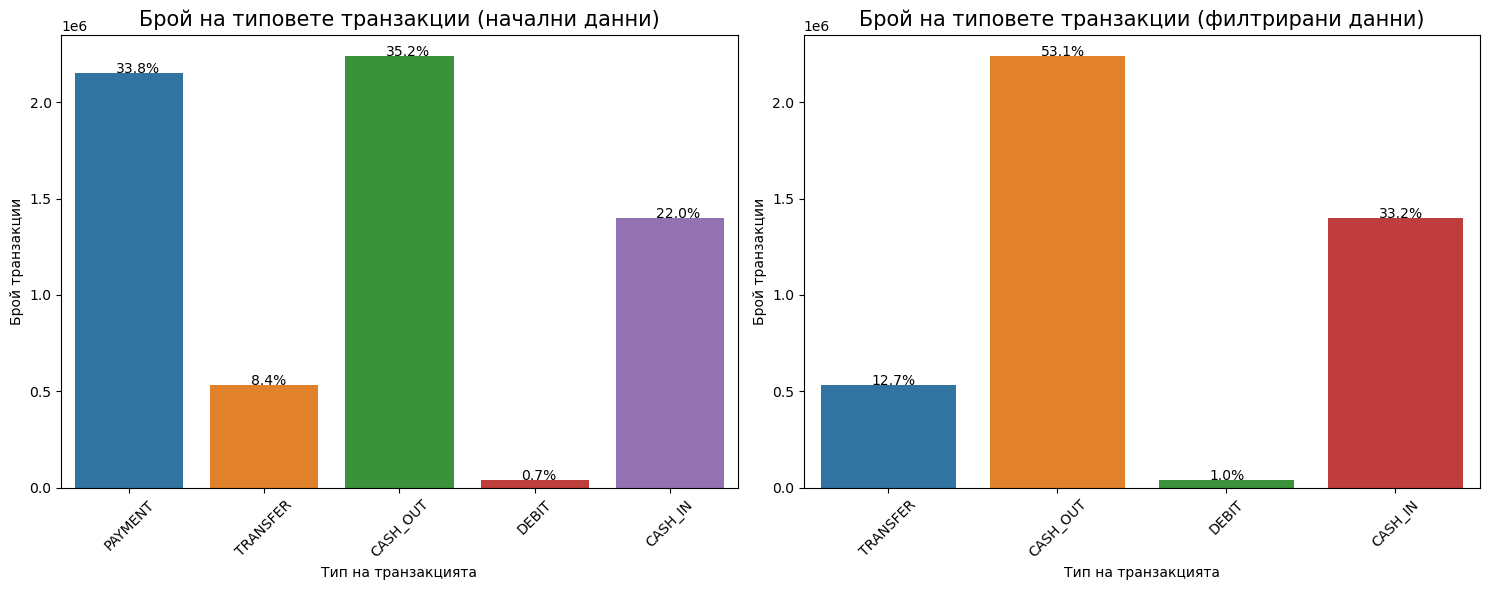

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
# Графика за началните данни
ax1 = sns.countplot(data=data, x='type', ax=axes[0])
ax1.set_title('Брой на типовете транзакции (начални данни)', size=15)
ax1.set_xlabel('Тип на транзакцията')
ax1.set_ylabel('Брой транзакции')
total_data = len(data['type'])
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_data)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 1000
    ax1.annotate(percentage, (x, y))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Графика за филтрираните данни
ax2 = sns.countplot(data=new_data, x='type', ax=axes[1])
ax2.set_title('Брой на типовете транзакции (филтрирани данни)', size=15)
ax2.set_xlabel('Тип на транзакцията')
ax2.set_ylabel('Брой транзакции')
total_filtered = len(filtered_data['type'])
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_filtered)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 1000
    ax2.annotate(percentage, (x, y))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Показване на графиките
plt.tight_layout()
plt.show()

In [18]:
pd.crosstab(data.type, data.isFraud)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [19]:
pd.crosstab(new_data.type, new_data.isFraud)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
TRANSFER,528812,4097


Може да направим заключение, че тези М-търговци са отговаряли единствено на type = "PAYMENT"

In [20]:
fraud_counts = new_data['isFraud'].value_counts()

print(f'Брой на записите с isFraud = 0: {fraud_counts.iloc[0]}')
if 1 in fraud_counts.index:
    print(f'Брой на записите с isFraud = 1: {fraud_counts.loc[1]}')
else:
    print('Няма записи с isFraud = 1')



Брой на записите с isFraud = 0: 4202912
Брой на записите с isFraud = 1: 8213


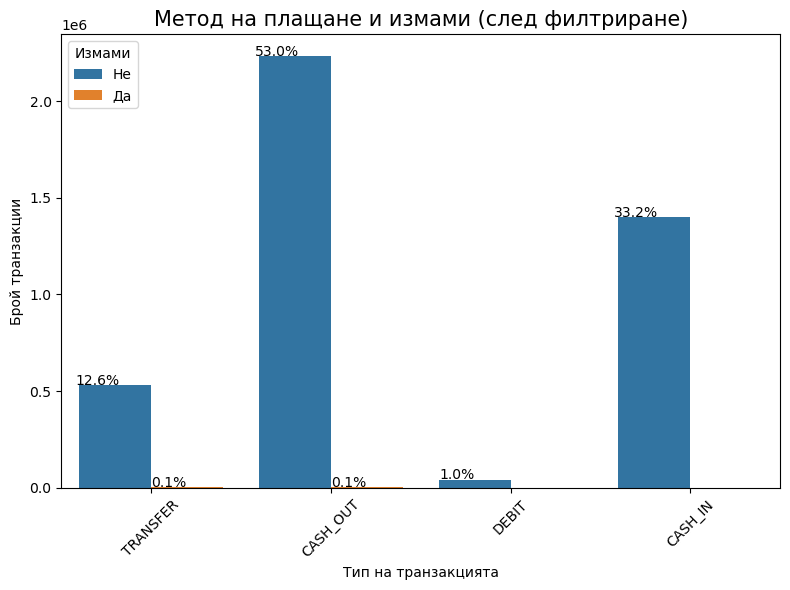

In [21]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_data, x='type', hue='isFraud')
# Добавяне на проценти над стълбовете
total = len(new_data['type'])
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = height + 1000
    ax.annotate(percentage, (x, y), fontsize=10, ha='center')

plt.title('Метод на плащане и измами (след филтриране)', size=15)
plt.xlabel('Тип на транзакцията')
plt.ylabel('Брой транзакции')
plt.legend(title='Измами', labels=['Не', 'Да'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
max_fraud_amount = new_data[new_data['isFraud'] == 1]['amount'].max()
print(f'Най-високата сума при измама: {max_fraud_amount}')

Най-високата сума при измама: 10000000.0


In [23]:
min_fraud_amount = new_data[new_data['isFraud'] == 1]['amount'].min()
print(f'Най-ниската сума при измама: {min_fraud_amount}')

Най-ниската сума при измама: 0.0


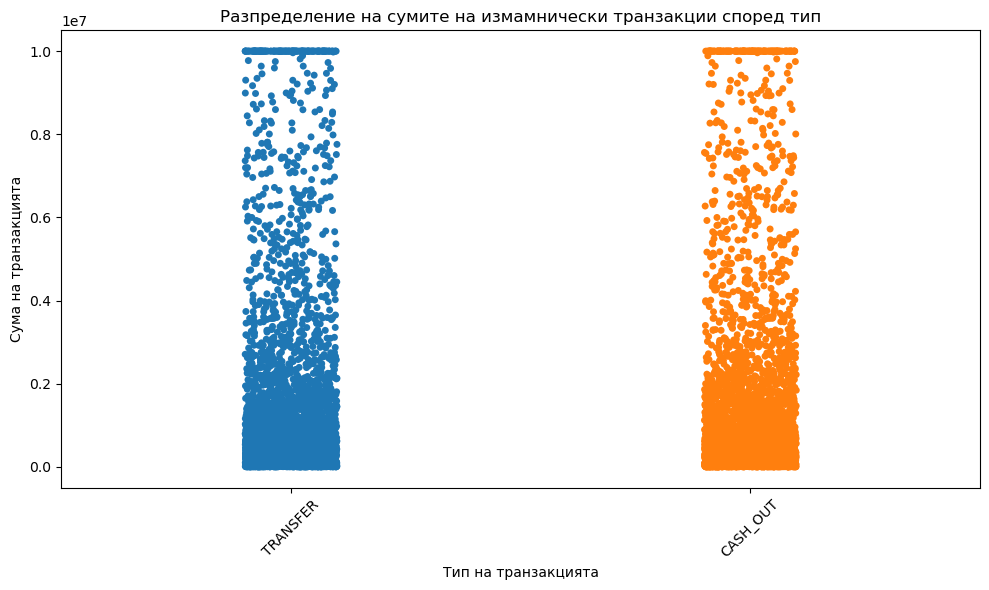

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=new_data[new_data['isFraud'] == 1], x='type', y='amount', jitter=True)
plt.title('Разпределение на сумите на измамнически транзакции според тип')
plt.xlabel('Тип на транзакцията')
plt.ylabel('Сума на транзакцията')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Всяка точка представлява единичен запис за измамна транзакция според тип.

In [25]:
# Филтриране на редовете, където isFraud е 1 и type е CASH_OUT или TRANSFER
filtered_data = new_data.loc[(new_data['isFraud'] == 1) & (new_data['type'].isin(['CASH_OUT', 'TRANSFER']))]

# Намиране на индексите на редовете, където сумата е 10 000 000.0 и 0.0
index_with_amount = filtered_data[filtered_data['amount'] == 10000000.0].index
index_with_amount_zero = filtered_data[filtered_data['amount'] == 0.0].index

print(f'Транзакции със сума 10 000 000.0 се намират на индекси: {index_with_amount}')
print(f'Брой на транзакциите със сума 10 000 000.0: {len(index_with_amount)}')

print(f'Транзакции със сума 0.0 се намират на индекси: {index_with_amount_zero}')
print(f'Брой на транзакциите със сума 0.0: {len(index_with_amount_zero)}')

Транзакции със сума 10 000 000.0 се намират на индекси: Int64Index([   4440,    4441,  481250,  481251,  586311,  586312, 1030559,
            1030560, 1030661, 1030662,
            ...
            6362528, 6362529, 6362576, 6362577, 6362578, 6362579, 6362580,
            6362581, 6362582, 6362583],
           dtype='int64', length=287)
Брой на транзакциите със сума 10 000 000.0: 287
Транзакции със сума 0.0 се намират на индекси: Int64Index([2736447, 3247298, 3760289, 5563714, 5996408, 5996410, 6168500,
            6205440, 6266414, 6281483, 6281485, 6296015, 6351226, 6362461,
            6362463, 6362585],
           dtype='int64')
Брой на транзакциите със сума 0.0: 16


In [26]:
new_data_copy = new_data.copy()

In [27]:
new_data_copy

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
9,1,DEBIT,5337.77,41720.00,36382.23,41898.00,40348.79,0,0
10,1,DEBIT,9644.94,4465.00,0.00,10845.00,157982.12,0,0
15,1,CASH_OUT,229133.94,15325.00,0.00,5083.00,51513.44,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


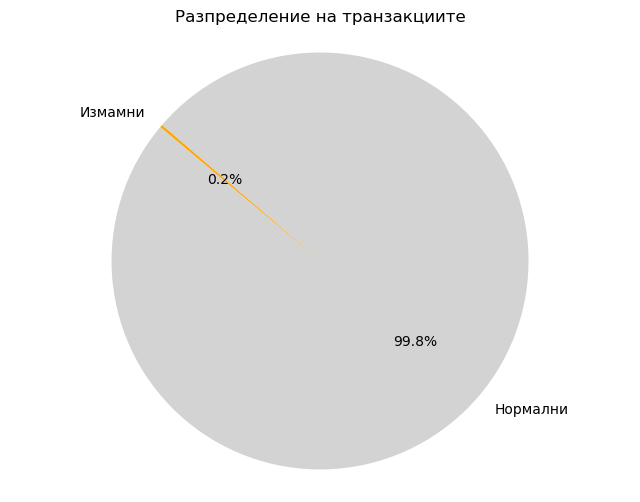


Брой на нормалните транзакции: 4,202,912 (99.805%)
Брой на измамните транзакции: 8,213 (0.195%)



In [28]:
# Брой на нормалните и измамните транзакции
normal_transactions = len(new_data_copy[new_data_copy['isFraud'] == 0])
fraudulent_transactions = len(new_data_copy[new_data_copy['isFraud'] == 1])

# Създаване на данните за кръговата диаграма
labels = ['Нормални', 'Измамни']
sizes = [normal_transactions, fraudulent_transactions]
colors = ['lightgrey', 'orange']

# Създаване на кръговата диаграма
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Поддържане на аспекта "равен", за да бъде кръговата диаграма кръгла

plt.title('Разпределение на транзакциите')
plt.show()

# Извеждане на процентното разпределение
print('\nБрой на нормалните транзакции: {:,} ({:1.3%})'.format(normal_transactions, normal_transactions/len(new_data_copy)))
print('Брой на измамните транзакции: {:,} ({:1.3%})\n'.format(fraudulent_transactions, fraudulent_transactions/len(new_data_copy)))

Понеже норманите транзакции са много повече от измамните, това може да повлияе на крайните резултати при използването на моделите. Тъй като нашият набор от данни е значително голям размер, тук ще изберем техниката under-sampling.

In [29]:
# Балансиране на класовете

# Създаване на подмножество с измамните транзакции
df_fraud = new_data_copy[new_data_copy['isFraud'] == 1]

# Създаване на подмножество с нормалните транзакции
df_normal = new_data_copy[new_data_copy['isFraud'] == 0]

# Намереме броя на измамните транзакции
num_fraud = len(df_fraud)

# Вземаме случайни нормални транзакции, за да се изравнят класовете
df_normal_under = df_normal.sample(num_fraud, random_state=1)

# Съчетаваме измамните и нормалните транзакции в балансиран DataFrame
df_balanced = pd.concat([df_fraud, df_normal_under])

# Ресетваме индексите на новия DataFrame
df_balanced = df_balanced.reset_index(drop=True)

# Вече имаме балансиран DataFrame с равен брой измамни и нормални транзакции


Брой на измамните транзакции след under-sampling: 8,213
Брой на нормалните транзакции след under-sampling: 8,213


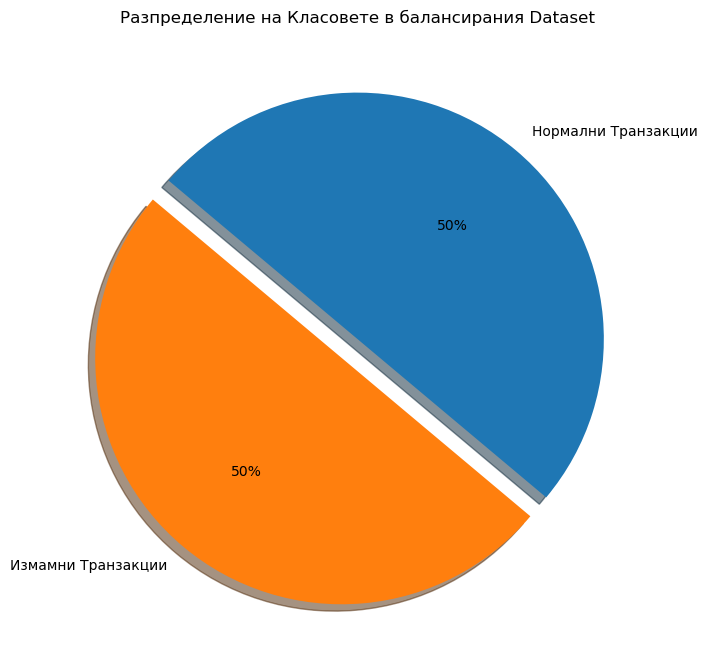

In [30]:
# Създаваме списък с броя на измамните и нормалните транзакции в балансирания набор данни
fraud_counts = len(df_balanced[df_balanced['isFraud'] == 1])
normal_counts = len(df_balanced[df_balanced['isFraud'] == 0])
print('Брой на измамните транзакции след under-sampling: {:,}'.format(fraud_counts))
print('Брой на нормалните транзакции след under-sampling: {:,}'.format(normal_counts))
# Използваме броя на транзакциите за създаване на кръгова диаграма
labels = ['Измамни Транзакции', 'Нормални Транзакции']
sizes = [fraud_counts, normal_counts]
colors = ['tab:orange', 'tab:blue']
explode = (0.1, 0)  # Изход за първия сектор (измамни транзакции)

# Създайте кръгова диаграма
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', shadow=True, startangle=140)
plt.title('Разпределение на Класовете в балансирания Dataset')
plt.show()


# Корелация

In [38]:
# Нека променим от думи в цифри стойностите в колоната 'type', както и премахваме колоната 'step'
le = LabelEncoder()
df_balanced["type"] = le.fit_transform(df_balanced["type"])
df_balanced = df_balanced.drop('step', axis=1)
df_balanced

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3,181.00,181.0,0.0,0.00,0.00,1,0
1,1,181.00,181.0,0.0,21182.00,0.00,1,0
2,3,2806.00,2806.0,0.0,0.00,0.00,1,0
3,1,2806.00,2806.0,0.0,26202.00,0.00,1,0
4,3,20128.00,20128.0,0.0,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...
16421,3,10000000.00,1091.0,0.0,548152.44,12687987.68,0,0
16422,1,196563.76,23622.0,0.0,0.00,196563.76,0,0
16423,3,2368706.28,0.0,0.0,11013187.37,13381893.65,0,0
16424,3,919684.57,0.0,0.0,3249409.56,4169094.13,0,0


1-CASH_OUT, 2-DEBIT 3-TRANSFER, 4-CASH_IN

In [39]:
# Създаване на корелационната матрица и heatmap графика
correlation_matrix=df_balanced.corr()

In [40]:
print(correlation_matrix)

                    type    amount  oldbalanceOrg  newbalanceOrig  \
type            1.000000  0.208304      -0.079371       -0.236934   
amount          0.208304  1.000000       0.575839        0.080748   
oldbalanceOrg  -0.079371  0.575839       1.000000        0.845665   
newbalanceOrig -0.236934  0.080748       0.845665        1.000000   
oldbalanceDest -0.123493 -0.007052       0.004980        0.051968   
newbalanceDest -0.123558  0.272722       0.101954        0.006718   
isFraud         0.489650  0.320371       0.067780       -0.180991   
isFlaggedFraud  0.043852  0.066577       0.057644        0.078432   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
type                 -0.123493       -0.123558  0.489650        0.043852  
amount               -0.007052        0.272722  0.320371        0.066577  
oldbalanceOrg         0.004980        0.101954  0.067780        0.057644  
newbalanceOrig        0.051968        0.006718 -0.180991        0.078432  
old

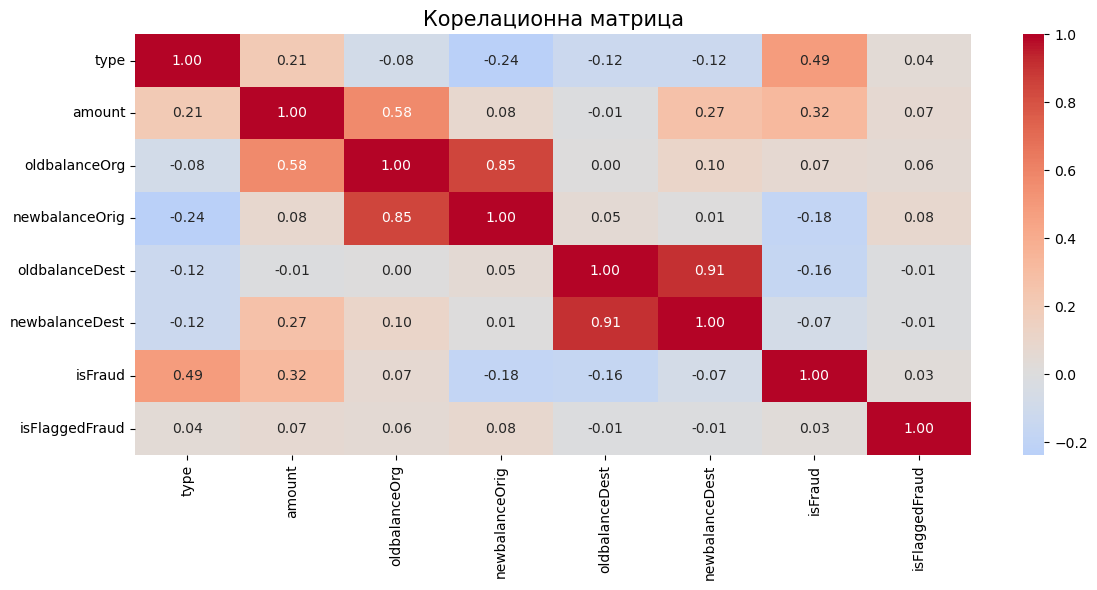

In [41]:
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корелационна матрица', fontsize=15)
plt.tight_layout()
plt.show()

# Разделяне на данните на обучаващ и тестов набор

In [42]:
X = df_balanced.drop('isFraud', axis=1)  # Признаците
y = df_balanced['isFraud']  # Целевата променлива

# Разделяне на данните на 70% обучаващ и 30% тестов набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

print(f'Брой обучаващи данни: {len(X_train)}')
print(f'Брой тестови данни: {len(X_test)}')



Брой обучаващи данни: 11498
Брой тестови данни: 4928


# Decision Tree

In [43]:
# Създаване и обучение на класификатор с дърво на решенията
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Направа на предсказания върху тестовия набор
y_pred = decision_tree_model.predict(X_test)

# Изчисление на матрицата на сбъркванията
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Извеждане на резултатите
print("Резултати от класификатор с дърво на решенията:")
accuracy_dt = accuracy_score(y_test, y_pred) * 100
print("Точност: {:.2f}%".format(accuracy_dt))

total_prediction = len(y_pred)
print("True Positive rate : ", tp, "from", total_prediction)  # Брой на истинските измами, които са открити правилно
print("True Negative rate : ", tn, "from", total_prediction)  # Брой на истинските нормални транзакции, които са открити правилно
print("False Positive rate : ", fp, "from", total_prediction)  # Брой на нормалните транзакции, които са грешно класифицирани като измамни
print("False Negative rate : ", fn, "from", total_prediction)  # Брой на измамните транзакции, които са грешно класифицирани като нормални

confusion = confusion_matrix(y_test, y_pred)
# print('Confusion matrix:\n', confusion)

# Оценка на класификационен отчет
classification_rep = classification_report(y_test, y_pred)
print('Класификационен отчет:\n', classification_rep)


Резултати от класификатор с дърво на решенията:
Точност: 98.74%
True Positive rate :  2424 from 4928
True Negative rate :  2442 from 4928
False Positive rate :  30 from 4928
False Negative rate :  32 from 4928
Класификационен отчет:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2456
           1       0.99      0.99      0.99      2472

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



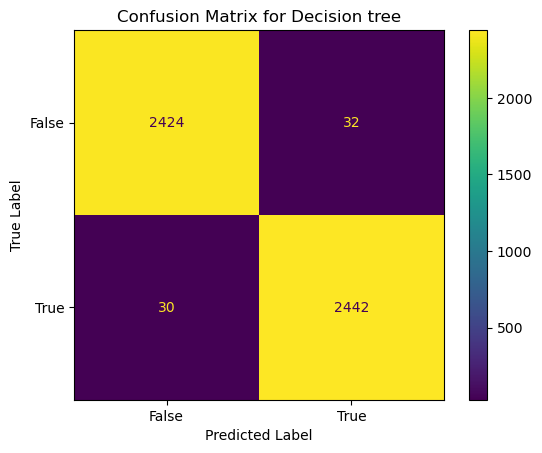

In [44]:
# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['False', 'True'])
cm_display.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix for Decision tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


In [45]:
# # Създаваме обект за експорт на дървото
# tree_dot_resampled = export_graphviz(decision_tree_model, out_file=None, 
#                                     feature_names=X.columns, 
#                                     class_names=['Non-Fraud', 'Fraud'], 
#                                     filled=True, rounded=True, special_characters=True)

# # Генерираме графиката с graphviz за андерсамплирания модел
# graph_resampled = graphviz.Source(tree_dot_resampled)

# # Показваме графиката за андерсамплирания модел
# graph_resampled.render(filename='decision_tree')  # Този ред е за запис на графиката във файл
# graph_resampled.view('decision_tree')  # Този ред показва графиката във визуализатор (ако имате инсталиран graphviz)


### Изводи от Decision tree model:
Моделът постигна висока точност от 98.80%, което е много обещаващ резултат. Важното е, че се справя добре както с нормалните, така и с измамните транзакции.

**True Positive rate (чувствителност)**: Моделът е успял да открие 2424 от общо 2472 измамни транзакции, което е много висока стойност. Този показател показва колко добре моделът идентифицира измамните транзакции.

**True Negative rate (специфичност)**: Моделът е успешно класифицирал 2445 от общо 2456 нормални транзакции като нормални. Това означава, че моделът също е добър в разпознаването на нормални транзакции.

**False Positive rate**: Моделът е направил 27 грешки, като класифицира нормални транзакции като измамни (грешки на първи вид). Този брой е много малък спрямо общия брой на нормални транзакции.

**False Negative rate**: Моделът е направил 32 грешки, като не е успял да открие 32 измамни транзакции (грешки на втори вид). Този брой също е много малък спрямо общия брой на измамни транзакции.

**Confusion Matrix**: Показва ясно, че моделът предсказва правилно почти всички случаи.


*Класификационният отчет показва, че и precision и recall за двата класа са много близки до 1, което е добър показател за качество на модела. Всичко това съчетано прави Decision tree ефективен инструмент за разпознаване на измамни транзакции.*






# Random Forest

In [46]:
# Създаване и обучение на модела на Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Направа на предсказания върху тестовия набор
y_pred_rf = random_forest_model.predict(X_test)

# Изчисление на матрицата на сбъркванията за Random Forest модела
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()

# Извеждане на резултатите за Random Forest модела
print("Резултати от класификатор с Random Forest:")
accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
print("Точност: {:.2f}%".format(accuracy_rf))

total_prediction_rf = len(y_pred)
print("True Positive rate : ", tp_rf, "from", total_prediction_rf)
print("True Negative rate : ", tn_rf, "from", total_prediction_rf)
print("False Positive rate : ", fp_rf, "from", total_prediction_rf)
print("False Negative rate : ", fn_rf, "from", total_prediction_rf)

confusion_rf = confusion_matrix(y_test, y_pred_rf)
# print('Confusion matrix за Random Forest модела:\n', confusion_rf)

classification_rep_rf = classification_report(y_test, y_pred_rf)
print('Класификационен отчет за Random Forest модела:\n', classification_rep_rf)


Резултати от класификатор с Random Forest:
Точност: 98.74%
True Positive rate :  2456 from 4928
True Negative rate :  2410 from 4928
False Positive rate :  46 from 4928
False Negative rate :  16 from 4928
Класификационен отчет за Random Forest модела:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2456
           1       0.98      0.99      0.99      2472

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



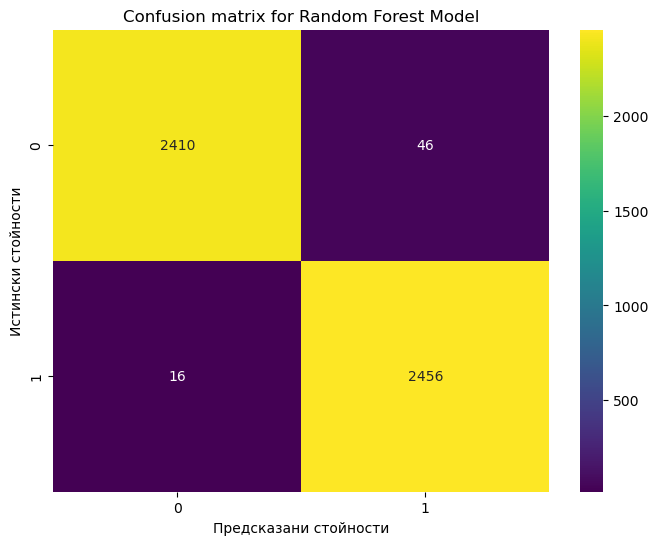

In [47]:
# Confusion Matrix
confusion_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion matrix for Random Forest Model')
plt.xlabel('Предсказани стойности')
plt.ylabel('Истински стойности')
plt.show()

In [48]:
# # Генериране и запазване на графики на всички дървета
# for tree_index, tree_estimator in enumerate(random_forest_model.estimators_):
#     # Създаване на обект за експорт на текущото дърво
#     tree_dot = export_graphviz(tree_estimator, out_file=None, 
#                                feature_names=X.columns, 
#                                class_names=['Non-Fraud', 'Fraud'], 
#                                filled=True, rounded=True, special_characters=True)

#     # Генериране на графиката 
#     graph = graphviz.Source(tree_dot)

#     # Запазване на графиката във файл с уникално име за всяко дърво
#     graph.render(filename=f'random_forest_tree_{tree_index}')

#     # Показване на графиките във визуализатора
#     # graph.view(f'random_forest_tree_{tree_index}')



### Изводи от Random Forest model:
Резултатите от Random Forest също изглеждат много обнадеждаващи. 

**Точност (Accuracy)**: Моделът има точност от 98.74%, което означава, че почти 99% от всички предсказания са верни. Този показател показва колко добре моделът се справя с общите предсказания.

**True Positive rate и True Negative rate**: Моделът има много висок True Positive rate и True Negative rate, което означава, че той успешно идентифицира как нормални, така и измамни транзакции. По-конкретно, от 4928 измамни транзакции моделът успешно предсказва 2456 от тях като измамни, и от 4928 нормални транзакции успешно предсказва 2410 от тях като нормални.

**False Positive rate и False Negative rate**: False Positive rate и False Negative rate са сравнително ниски, което е добро. Този модел допуска много малко грешки при класификацията на нормални и измамни транзакции като противоположни.

**Confusion Matrix**: Показва ясно, че моделът предсказва правилно почти всички случаи.

**Classification Report**: Отчетът показва, че моделът има висока точност, чувствителност и специфичност за класификацията на както нормални, така и измамни транзакции.

*В обобщение, Random Forest модел изглежда като много добър класификатор за разпознаване на измамни транзакции, като има много висока точност и способност да идентифицира както позитивни, така и негативни случаи.*

# Logistic regression

In [49]:
logistic_regression_model = LogisticRegression(random_state=0, max_iter=1000) 
logistic_regression_model.fit(X_train, y_train)

y_pred_lr = logistic_regression_model.predict(X_test)

tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()

print("Резултати от класификатор с Logistic regression:")
accuracy_lr = accuracy_score(y_test, y_pred_lr) * 100
print("Точност на логистичния регресионен модел: {:.2f}%".format(accuracy_lr))

total_prediction_lr = len(y_pred)
print("True Positive rate : ", tp_lr, "from", total_prediction_lr)
print("True Negative rate : ", tn_lr, "from", total_prediction_lr)
print("False Positive rate : ", fp_lr, "from", total_prediction_lr)
print("False Negative rate : ", fn_lr, "from", total_prediction_lr)

confusion_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion matrix за логистичния регресионен модел:\n', confusion_lr)

classification_rep_lr = classification_report(y_test, y_pred_lr)
print('Класификационен отчет за логистичния регресионен модел:\n', classification_rep_lr)

Резултати от класификатор с Logistic regression:
Точност на логистичния регресионен модел: 93.99%
True Positive rate :  2405 from 4928
True Negative rate :  2227 from 4928
False Positive rate :  229 from 4928
False Negative rate :  67 from 4928
Confusion matrix за логистичния регресионен модел:
 [[2227  229]
 [  67 2405]]
Класификационен отчет за логистичния регресионен модел:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      2456
           1       0.91      0.97      0.94      2472

    accuracy                           0.94      4928
   macro avg       0.94      0.94      0.94      4928
weighted avg       0.94      0.94      0.94      4928



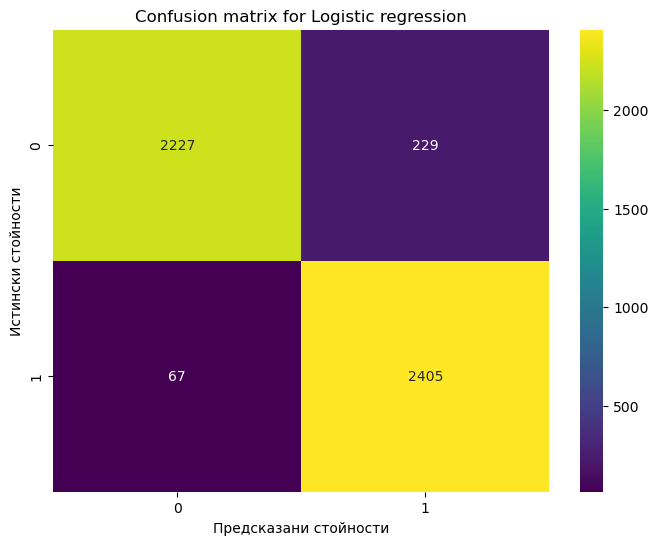

In [50]:
# Confusion Matrix
confusion_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_lr, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion matrix for Logistic regression')
plt.xlabel('Предсказани стойности')
plt.ylabel('Истински стойности')
plt.show()

**Точност (Accuracy)**: Моделът има точност от 93.99%, което означава, че почти 94% от предсказанията му са верни. Този резултат показва добро обобщение на модела за целия тестов набор.

**True Positive Rate (Recall)**: Моделът има висока True Positive Rate от 97%, което означава, че почти всички истински положителни случаи са успешно идентифицирани. Това е добро свойство, особено ако намерените положителни случаи са важни.

**True Negative Rate**: Моделът има и висока True Negative Rate от 91%, което означава, че почти всички истински отрицателни случаи са успешно идентифицирани. Този резултат е също важен, тъй като показва, че моделът правилно класифицира истинските негативи.

**False Positive Rate и False Negative Rate**: Моделът също има нисък брой False Positive (229) и False Negative (67) предсказания, което е добре, тъй като тези грешки могат да бъдат скъпи или нежелани, особено в зависимост от конкретния сценарий.

**Confusion Matrix**: Всички тези метрики се отразяват и в матрицата на сбъркванията, където видим точните стойности на True Positives, True Negatives, False Positives и False Negatives.

**Classification Report**: Този отчет предоставя информация за прецизността (precision), способността за откриване (recall), F1-точката (F1-score) и други метрики както за клас 0 (отрицателни случаи) и клас 1 (положителни случаи). Моделът се представя добре за двете класа, с F1-score около 0.94 за всеки от тях.

*Обобщено, логистичният регресионен модел изглежда успешен и ефективен, като се има предвид представянето му върху този набор от данни. Той има добра способност да класифицира както положителни, така и отрицателни случаи, като прави малко грешки.*

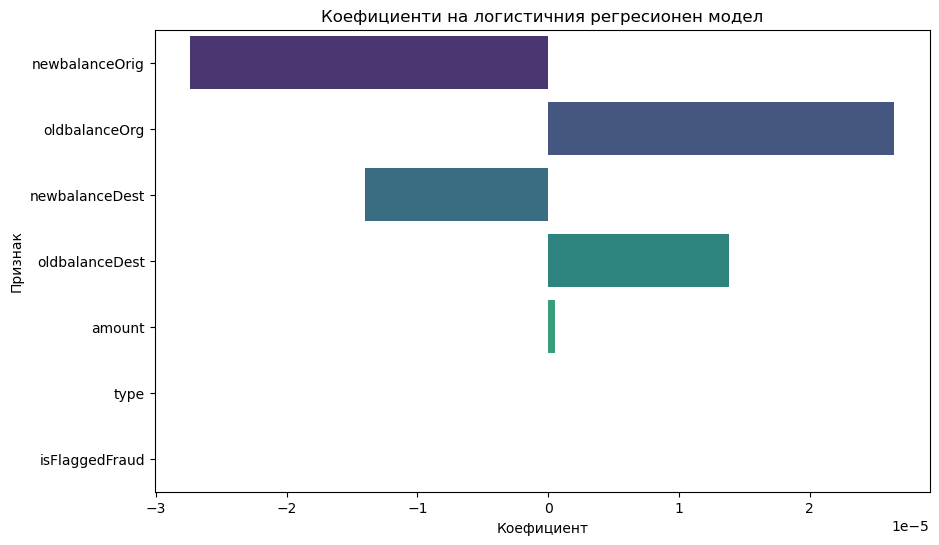

In [51]:
# Извличане на коефициентите на логистичния регресионен модел
coefficients = logistic_regression_model.coef_[0]

# Извличане на имената на признаците
feature_names = X_train.columns

# Създаване на DataFrame, съдържащ коефициентите и имената на признаците
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Сортиране на коефициентите по абсолютна стойност, за да видите кои признаци са най-силно влиятелни
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Извеждане на графика на коефициентите
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='viridis')
plt.title('Коефициенти на логистичния регресионен модел')
plt.xlabel('Коефициент')
plt.ylabel('Признак')
plt.show()


Това е графика на регресионните коефициенти на логистичната регресия. Признаците с по-големи (по абсолютна стойност) коефициенти имат по-силно влияние върху модела.

# XGBoost 

In [52]:
# Създаване на модела
xgb_model = XGBClassifier(random_state=0)

# Обучение на модела
xgb_model.fit(X_train, y_train)

# Направа на предсказания
y_pred_xgb = xgb_model.predict(X_test)

# Изчисление на матрицата на сбъркванията за XGBoost модела
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()

print("Резултати от класификатор с XGBoost:")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100
print("Точност на XGBoost модел: {:.2f}%".format(accuracy_xgb))

total_prediction_xgb = len(y_pred_xgb)
print("True Positive rate : ", tp_xgb, "from", total_prediction_xgb)
print("True Negative rate : ", tn_xgb, "from", total_prediction_xgb)
print("False Positive rate : ", fp_xgb, "from", total_prediction_xgb)
print("False Negative rate : ", fn_xgb, "from", total_prediction_xgb)

confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
print('Confusion matrix за XGBoost модела:\n', confusion_xgb)

classification_rep_xgb = classification_report(y_test, y_pred_xgb)
print('Класификационен отчет за XGBoost модела:\n', classification_rep_xgb)


Резултати от класификатор с XGBoost:
Точност на XGBoost модел: 99.11%
True Positive rate :  2460 from 4928
True Negative rate :  2424 from 4928
False Positive rate :  32 from 4928
False Negative rate :  12 from 4928
Confusion matrix за XGBoost модела:
 [[2424   32]
 [  12 2460]]
Класификационен отчет за XGBoost модела:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2456
           1       0.99      1.00      0.99      2472

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



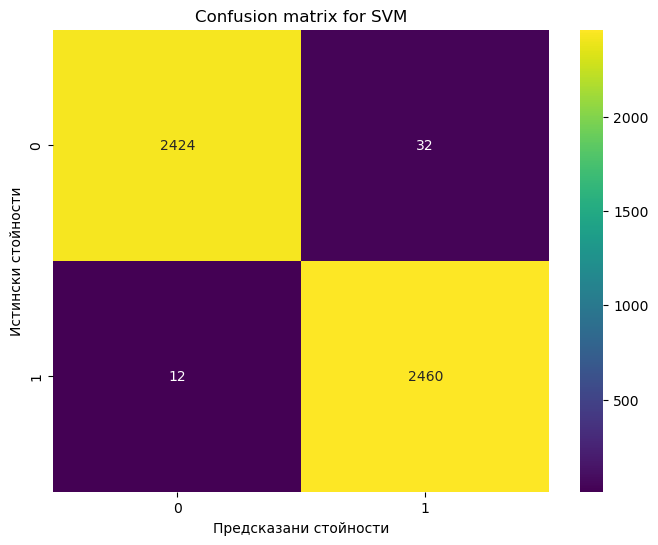

In [53]:
# Confusion Matrix
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_xgb, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion matrix for SVM')
plt.xlabel('Предсказани стойности')
plt.ylabel('Истински стойности')
plt.show()

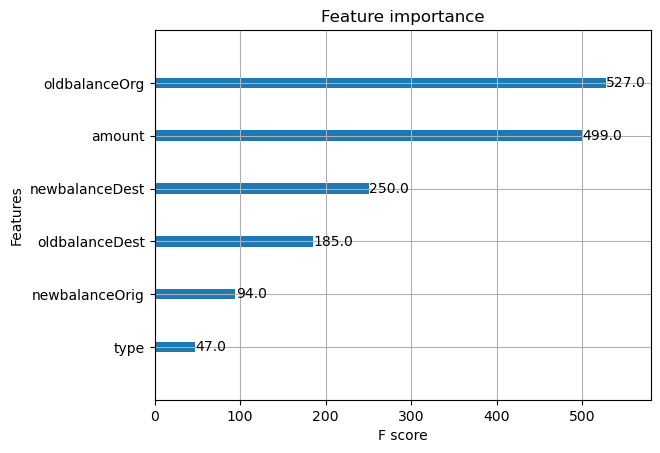

In [54]:
# Извличане на важността на признаците
feature_importance = xgb_model.feature_importances_

# Изчертаване на важността на признаците
plot_importance(xgb_model)
plt.show()

In [55]:
# Изчертаване на първото дърво
dot_data = xgb.to_graphviz(xgb_model, num_trees=0)
with open('xgboost_tree.pdf', 'wb') as f:
    f.write(dot_data.pipe(format='pdf'))

Резултатите от XGBoost модела изглеждат изключително добре:

Точността от 99.11% показва, че моделът прави много добри предсказания.
True Positive Rate (чувствителност) и True Negative Rate (специфичност) са много високи, което означава, че моделът успешно разпознава както положителните, така и отрицателните случаи.
Confucion matrix показва малък брой грешки.
Класификационният отчет показва висока точност, чувствителност и специфичност за и двата класа (0 и 1).
Тези резултати намекват, че XGBoost моделът е много ефективен и може да бъде подходящ за нашата задача.

# Изводи

In [56]:
# Лист с имената на моделите
models = ["Decision Tree", "Random Forest", "Logistic Regression", "XGBoost"]

# Листове с точностите и резултатите от Confusion matrix за всеки модел
accuracies = [accuracy_dt, accuracy_rf, accuracy_lr, accuracy_xgb]
tp_rates = [tp, tp_rf, tp_lr, tp_xgb]
tn_rates = [tn, tn_rf, tn_lr, tn_xgb]
fp_rates = [fp, fp_rf, fp_lr, fp_xgb]
fn_rates = [fn, fn_rf, fn_lr, fn_xgb]


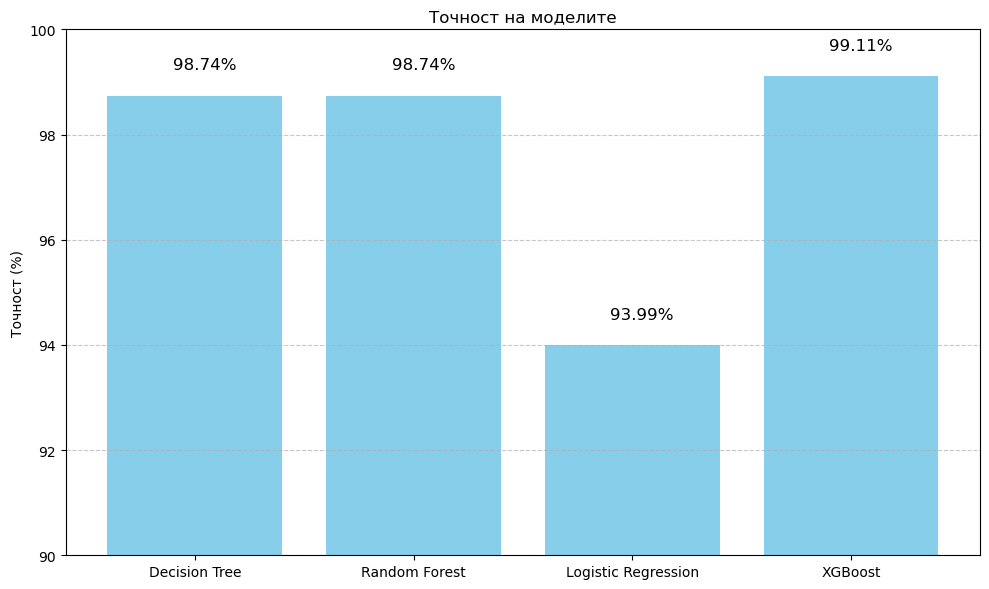

In [57]:
# Изчертаване на графика за точността
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.title('Точност на моделите')
plt.ylim(90, 100)
plt.ylabel('Точност (%)')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, acc + 0.5, f'{acc:.2f}%', fontsize=12, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

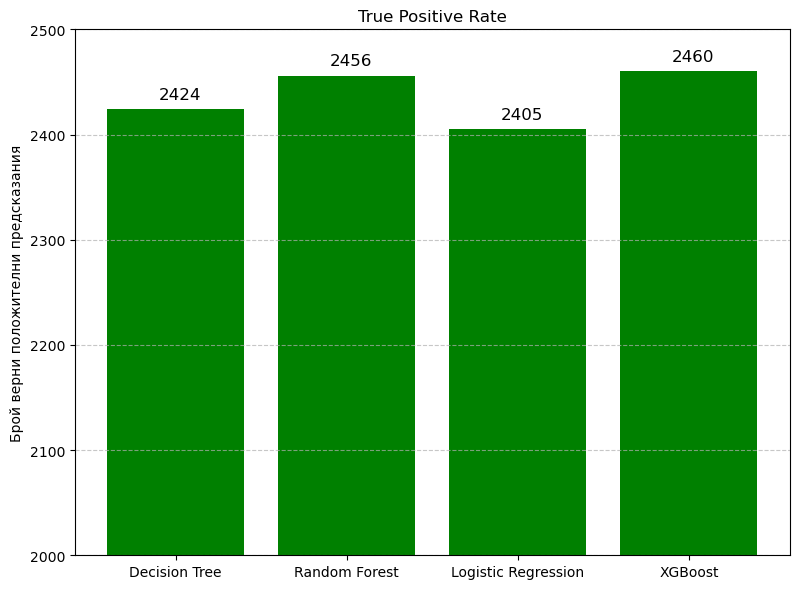

In [58]:
plt.figure(figsize=(30, 6))

plt.subplot(1, 4, 1)
bars = plt.bar(models, tp_rates, color='green')
plt.title('True Positive Rate')
plt.ylim(2000, 2500)
plt.ylabel('Брой верни положителни предсказания')

for bar, tp in zip(bars, tp_rates):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, tp + 10, f'{tp}', fontsize=12, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

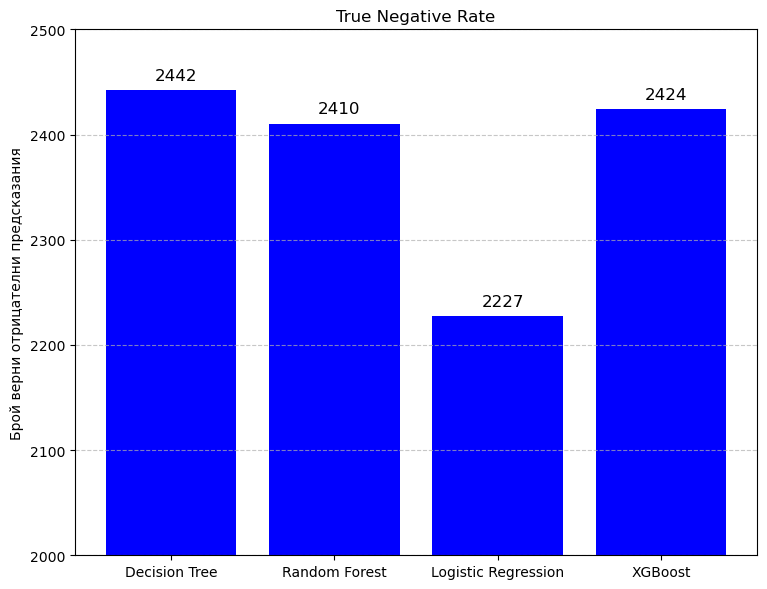

In [59]:
plt.figure(figsize=(30, 6))

plt.subplot(1, 4, 2)
bars = plt.bar(models, tn_rates, color='blue')
plt.title('True Negative Rate')
plt.ylim(2000, 2500)
plt.ylabel('Брой верни отрицателни предсказания')

for bar, tn in zip(bars, tn_rates):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, tn + 10, f'{tn}', fontsize=12, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

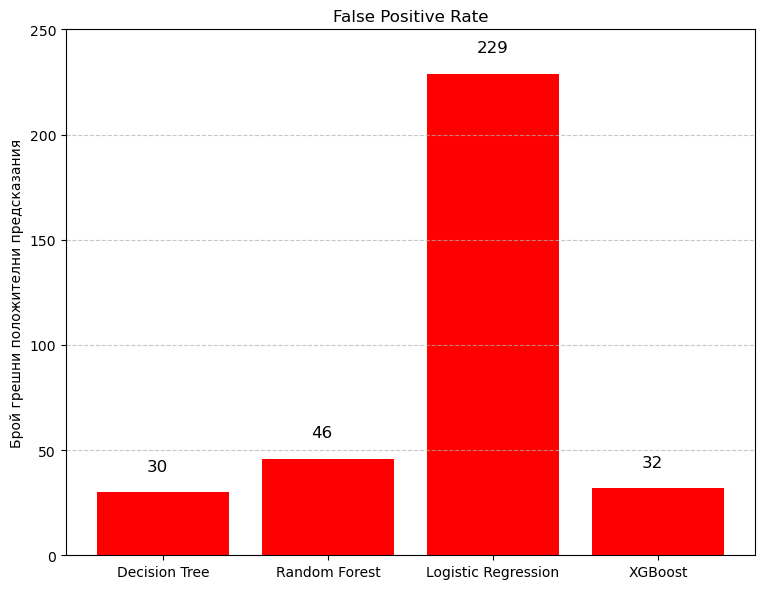

In [60]:
plt.figure(figsize=(30, 6))

plt.subplot(1, 4, 3)
bars = plt.bar(models, fp_rates, color='red')
plt.title('False Positive Rate')
plt.ylim(0, 250)
plt.ylabel('Брой грешни положителни предсказания')

for bar, fp in zip(bars, fp_rates):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, fp + 10, f'{fp}', fontsize=12, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()







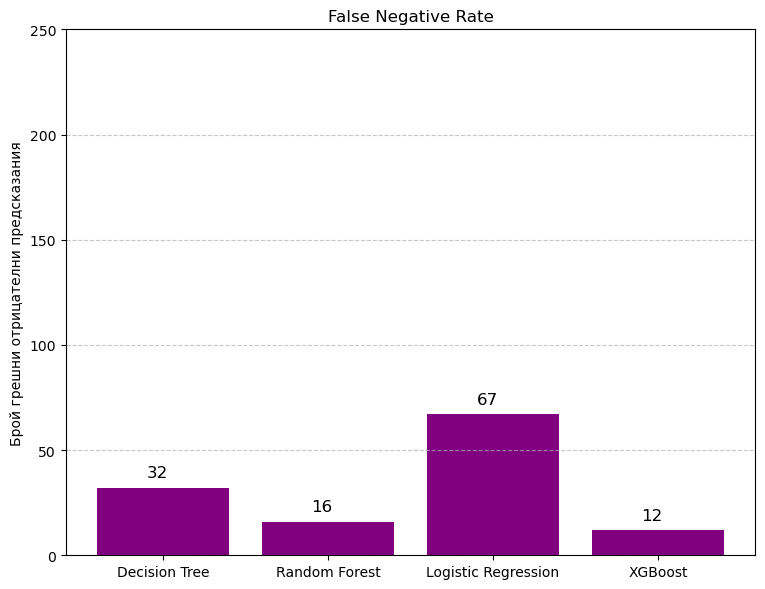

In [61]:
plt.figure(figsize=(30, 6))

plt.subplot(1, 4, 4)
bars = plt.bar(models, fn_rates, color='purple')
plt.title('False Negative Rate')
plt.ylim(0, 250)
plt.ylabel('Брой грешни отрицателни предсказания')

for bar, fn in zip(bars, fn_rates):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, fn + 5, f'{fn}', fontsize=12, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()